In this notebook, we compare differences between describing the scope entries by using features of their substrates or their product.

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pathlib import Path
import pandas as pd
import numpy as np
import shutil
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from Code.benchmark import Benchmark
from Code.utils import obtain_full_covar_matrix
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys


# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
    })

In [2]:
datasets = ["high","medium","low"]

### Generate data for scopes run using descriptors of the reaction products

Establish the bounds for scope runs when the entries are featurized using their products

In [3]:
# # run scopes to get the bounds
# for dset in datasets:
#     Benchmark().collect_data(
#         filename_labelled = f"./../Amide_data/Datasets/amide_dset_dft_prod_{dset}-yielding.csv",  
#         name_results = f"./Results_Data/Prod_Feat/Bounds/40greedy-{dset}", objectives=['yield'], 
#         budget = 40, batches= [1,2,3,4], Vendi_pruning_fractions = [0], seeds = 40, 
#         acquisition_function_mode= "greedy", pruning_metric= "vendi_batch", init_sampling_method="random",
#         filename_prediction="adfadf.csv")

#     # most extreme vendi pruning for a scope of 40 samples for the different batch sizes
#     extreme_pruning_40 = {1: 8, 2: 17, 3: 25, 4: 33}
#     # Run the scopes
#     for batch in extreme_pruning_40:
#         Benchmark().collect_data(
#             filename_labelled = f"./../Amide_data/Datasets/amide_dset_dft_prod_{dset}-yielding.csv",  
#             name_results = f"./Results_Data/Prod_Feat/Bounds/40explorative-{dset}/40explorative_b{batch}", 
#             objectives=['yield'], budget = 40, batches= [batch], 
#             Vendi_pruning_fractions = [extreme_pruning_40[batch]], 
#             seeds = 40, acquisition_function_mode= "explorative", pruning_metric= "vendi_batch", 
#             init_sampling_method="random", filename_prediction = "adfsaf.csv")

In [4]:
# create a dataframe to save the normalization bounds
df_bounds = pd.DataFrame(np.nan,index=["obj_min","obj_max","vendi_min","vendi_max"],columns= datasets)
# Get the data
for dset in datasets:
    vendi_explore_max_40 = []
    for batch in [1,2,3,4]:
        df_explore_max_40 = Benchmark().heatmap_plot(type_results="vendi",
                                                     name_results=f"./Results_Data/Prod_Feat/Bounds/"\
                                                        f"40explorative-{dset}/40explorative_b{batch}",
                                                     budget=40,show_plot=False)
        vendi_explore_max_40.append(df_explore_max_40.max().max())  # recording the highest Vendi score for this scope
    df_bounds.loc["vendi_max",dset] = max(vendi_explore_max_40)
    obj_explore_max_40 = []
    for batch in [1,2,3,4]:
        df_explore_max_40 = Benchmark().heatmap_plot(type_results="objective",
                                                     name_results=f"./Results_Data/Prod_Feat/Bounds/"\
                                                        f"40explorative-{dset}/40explorative_b{batch}",
                                                     budget=40,show_plot=False)
        obj_explore_max_40.append(df_explore_max_40.min().min())  # recording the lowest average objective for this scope
    df_bounds.loc["obj_min",dset]  = min(obj_explore_max_40)
    df_greedy_40_vendi = Benchmark().heatmap_plot(type_results="vendi",name_results=f"./Results_Data/Prod_Feat"\
                                                  f"/Bounds/40greedy-{dset}",budget=40,show_plot=False)
    df_bounds.loc["vendi_min",dset] = df_greedy_40_vendi.min().min()
    df_greedy_40_obj = Benchmark().heatmap_plot(type_results="objective",name_results=f"./Results_Data/Prod_Feat"\
                                                f"/Bounds/40greedy-{dset}",budget=40,show_plot=False)
    df_bounds.loc["obj_max",dset] = df_greedy_40_obj.max().max()
df_bounds

high    medium       low
obj_min    0.565997  0.358398  0.171382
obj_max    0.706715  0.449077  0.333828
vendi_min  2.501266  2.710769  2.643337
vendi_max  7.361190  7.338983  7.308320

In [5]:
# define a function to extract the relevant bounds in a format suitable for the Benchmark class
def get_bounds(dset):
    bounds = {}
    # get the metrics for the rate objective
    bounds["yield"] = (df_bounds.loc["obj_max",dset],df_bounds.loc["obj_min",dset])
    # get the metrics for the vendi score
    bounds["vendi"] = (df_bounds.loc["vendi_max",dset],df_bounds.loc["vendi_min",dset])

    return bounds

Run scopes for benchmark comparisons using product descriptors

In [6]:
# for dset in datasets:
#     for acq in ["ei","random-selection","greedy","explorative"]:
#         if acq == "ei":
#             acq_label = "balanced"
#         elif acq == "random-selection":
#             acq_label = "random"
#         else:
#             acq_label = acq
#         for pruning in [False,True]:
#             if pruning:
#                 pruning_label = "with-pruning"
#                 pruning_fraction = 13
#             else:
#                 pruning_label = "no-pruning"
#                 pruning_fraction = 0
#             Benchmark().collect_data(
#                 filename_labelled = f"./../Amide_data/Datasets/amide_dset_dft_prod_{dset}-yielding.csv",
#                 name_results = f"./Results_Data/Prod_Feat/{dset}-dataset/{acq}_{pruning_label}",
#                 objectives=['yield'],
#                 budget = 27,
#                 batches= [3],
#                 Vendi_pruning_fractions = [pruning_fraction],
#                 seeds = 40,
#                 acquisition_function_mode= acq_label,
#                 pruning_metric= "vendi_batch",
#                 init_sampling_method="random"
#                 )

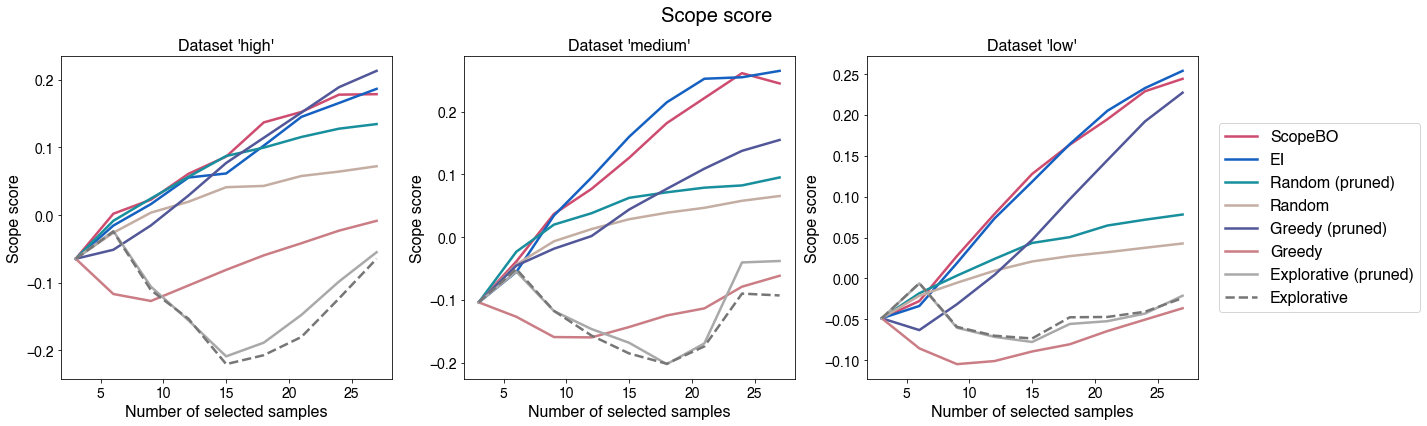

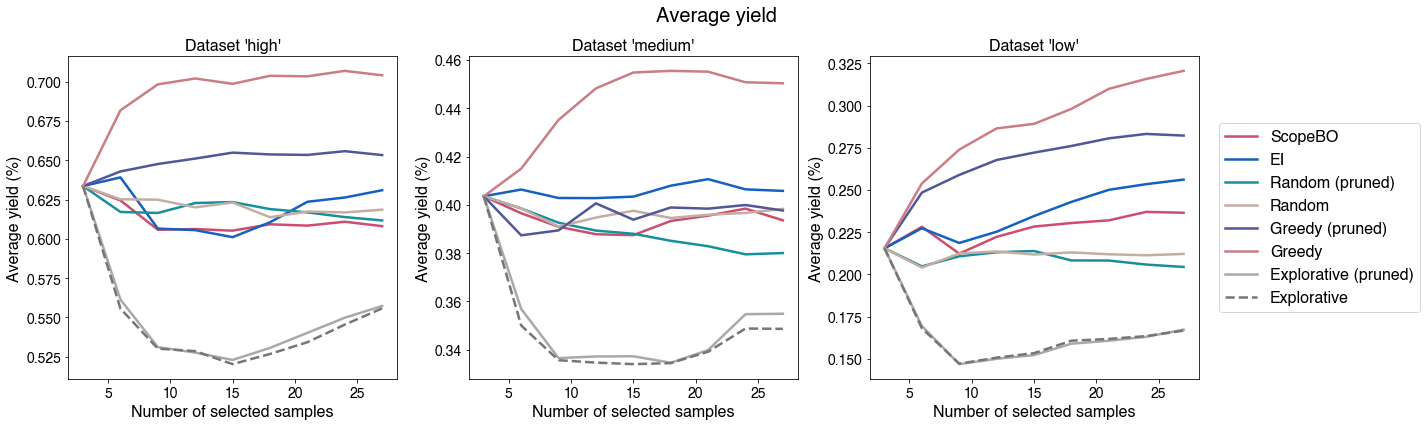

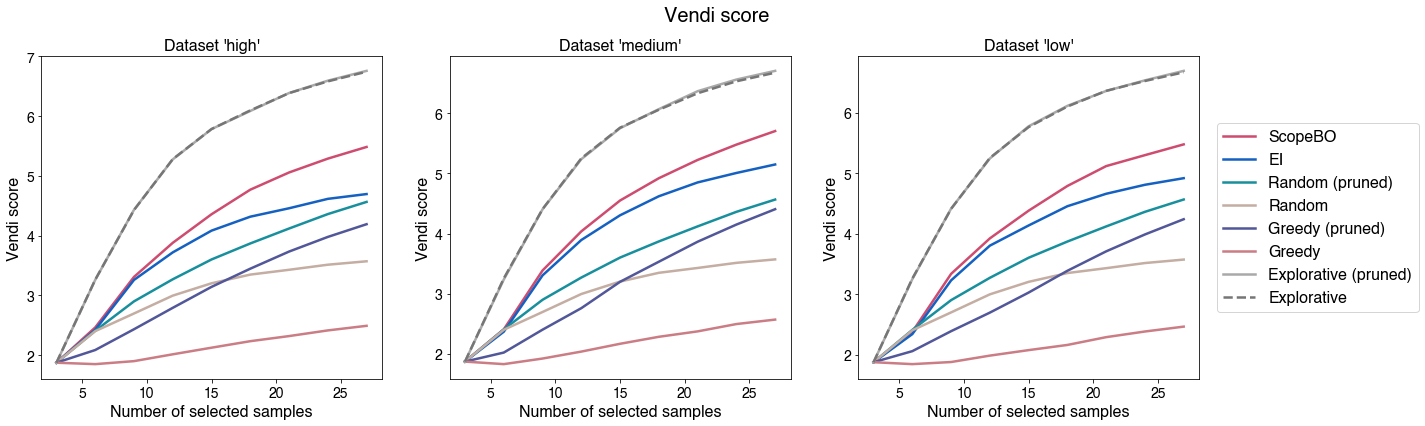

In [7]:
dfs_results = {}
def score_overview(metrics):
    for type_results in metrics:
        # Initialize the figure
        fig, axes = plt.subplots(1,4,figsize=(20,6), gridspec_kw={'width_ratios': [1, 1, 1, 0.3]})
        if type_results == "Yield":
            fig.suptitle("Average yield", fontsize=20)
        else:
            fig.suptitle(f"{type_results} score",fontsize=20)
        # Go through the datasets
        for i,dset in enumerate(datasets):
            dfs = {}
            # Get the data for all acquisition functions
            for acq in ["EI","Random","Greedy","Explorative"]:
                if acq.lower() == "random":
                    acq_label = "random-selection"
                else:
                    acq_label = acq.lower()
                for pruning in [True,False]:
                    if pruning:
                        pruning_label = "with-pruning"
                    else:
                        pruning_label = "no-pruning"
                    dfs_progress = Benchmark().progress_plot(budget=27, type_results= type_results,
                                            name_results=f"Results_Data/Prod_Feat/{dset}-dataset"\
                                                f"/{acq_label}_{pruning_label}",
                                            bounds=get_bounds(dset),show_plot=False)
                    if type_results.lower() == "objective":
                        dfs_progress["means"] = dfs_progress["means"].applymap(lambda x: x*100)  # scale yields from [0,1] to [0,100]
                    dfs[acq+"_"+pruning_label] = dfs_progress["means"]
            # Combine the results and plot them
            df_combined = pd.concat(dfs,axis=1)
            df_combined.columns = [multiindex[0] for multiindex in df_combined.columns]
            df_combined.rename(columns={"EI_with-pruning":"ScopeBO"},inplace=True)
            df_combined = df_combined[["ScopeBO"] + [col for col in df_combined.columns if col != "ScopeBO"]]
            label_dict = {col: col for col in df_combined.columns}
            for key,val in label_dict.items():
                if "_no-pruning" in val:
                    label_dict[key] = val.split("_")[0]
                elif "with-pruning" in val:
                    label_dict[key] = val.split("_")[0] + " (pruned)"
            df_combined.rename(columns=label_dict,inplace=True)
            dfs_results[f"{dset}_{type_results}"] = df_combined
            for j,col in enumerate(df_combined.columns):
                style = '-' if j <= 6 else '--' if j <= 13 else ':'
                plotting = df_combined[col][df_combined[col].notna()]
                axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)
            # Collect the labels for the legend
            if i == 0:
                handles_collected, labels_collected = axes[i].get_legend_handles_labels()
            axes[i].set_xlabel('Number of selected samples',fontsize=16)
            if type_results == "Yield":
                axes[i].set_ylabel(f"Average yield (%)",fontsize=16)
            else:
                axes[i].set_ylabel(f"{type_results} score",fontsize=16)
            axes[i].set_title(f"Dataset '{dset}'",fontsize=16)

            # Last subplot is used for the shared legend
            axes[3].axis('off')
            axes[3].legend(handles=handles_collected, labels=labels_collected,
                        fontsize=16, loc='center')
            
        plt.tight_layout()
        plt.show()

dfs = score_overview(["Scope","Yield","Vendi"])

In [8]:
final_scopes = {}
# get the final metric for the datasets
for dset in datasets:
    final_scope = pd.DataFrame(np.nan, index = ["Scope","Yield","Vendi"], columns = dfs_results["high_Scope"].columns)
    for idx in final_scope.index:
        for col in final_scope.columns:
            final_scope.loc[idx,col] = dfs_results[f"{dset}_{idx}"][col].iloc[-1]
    final_scope = final_scope[["Greedy","Greedy (pruned)", "EI","ScopeBO","Random","Random (pruned)","Explorative","Explorative (pruned)"]]
    # Normalize each metric
    final_scope = final_scope.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
    final_scopes[dset] = final_scope

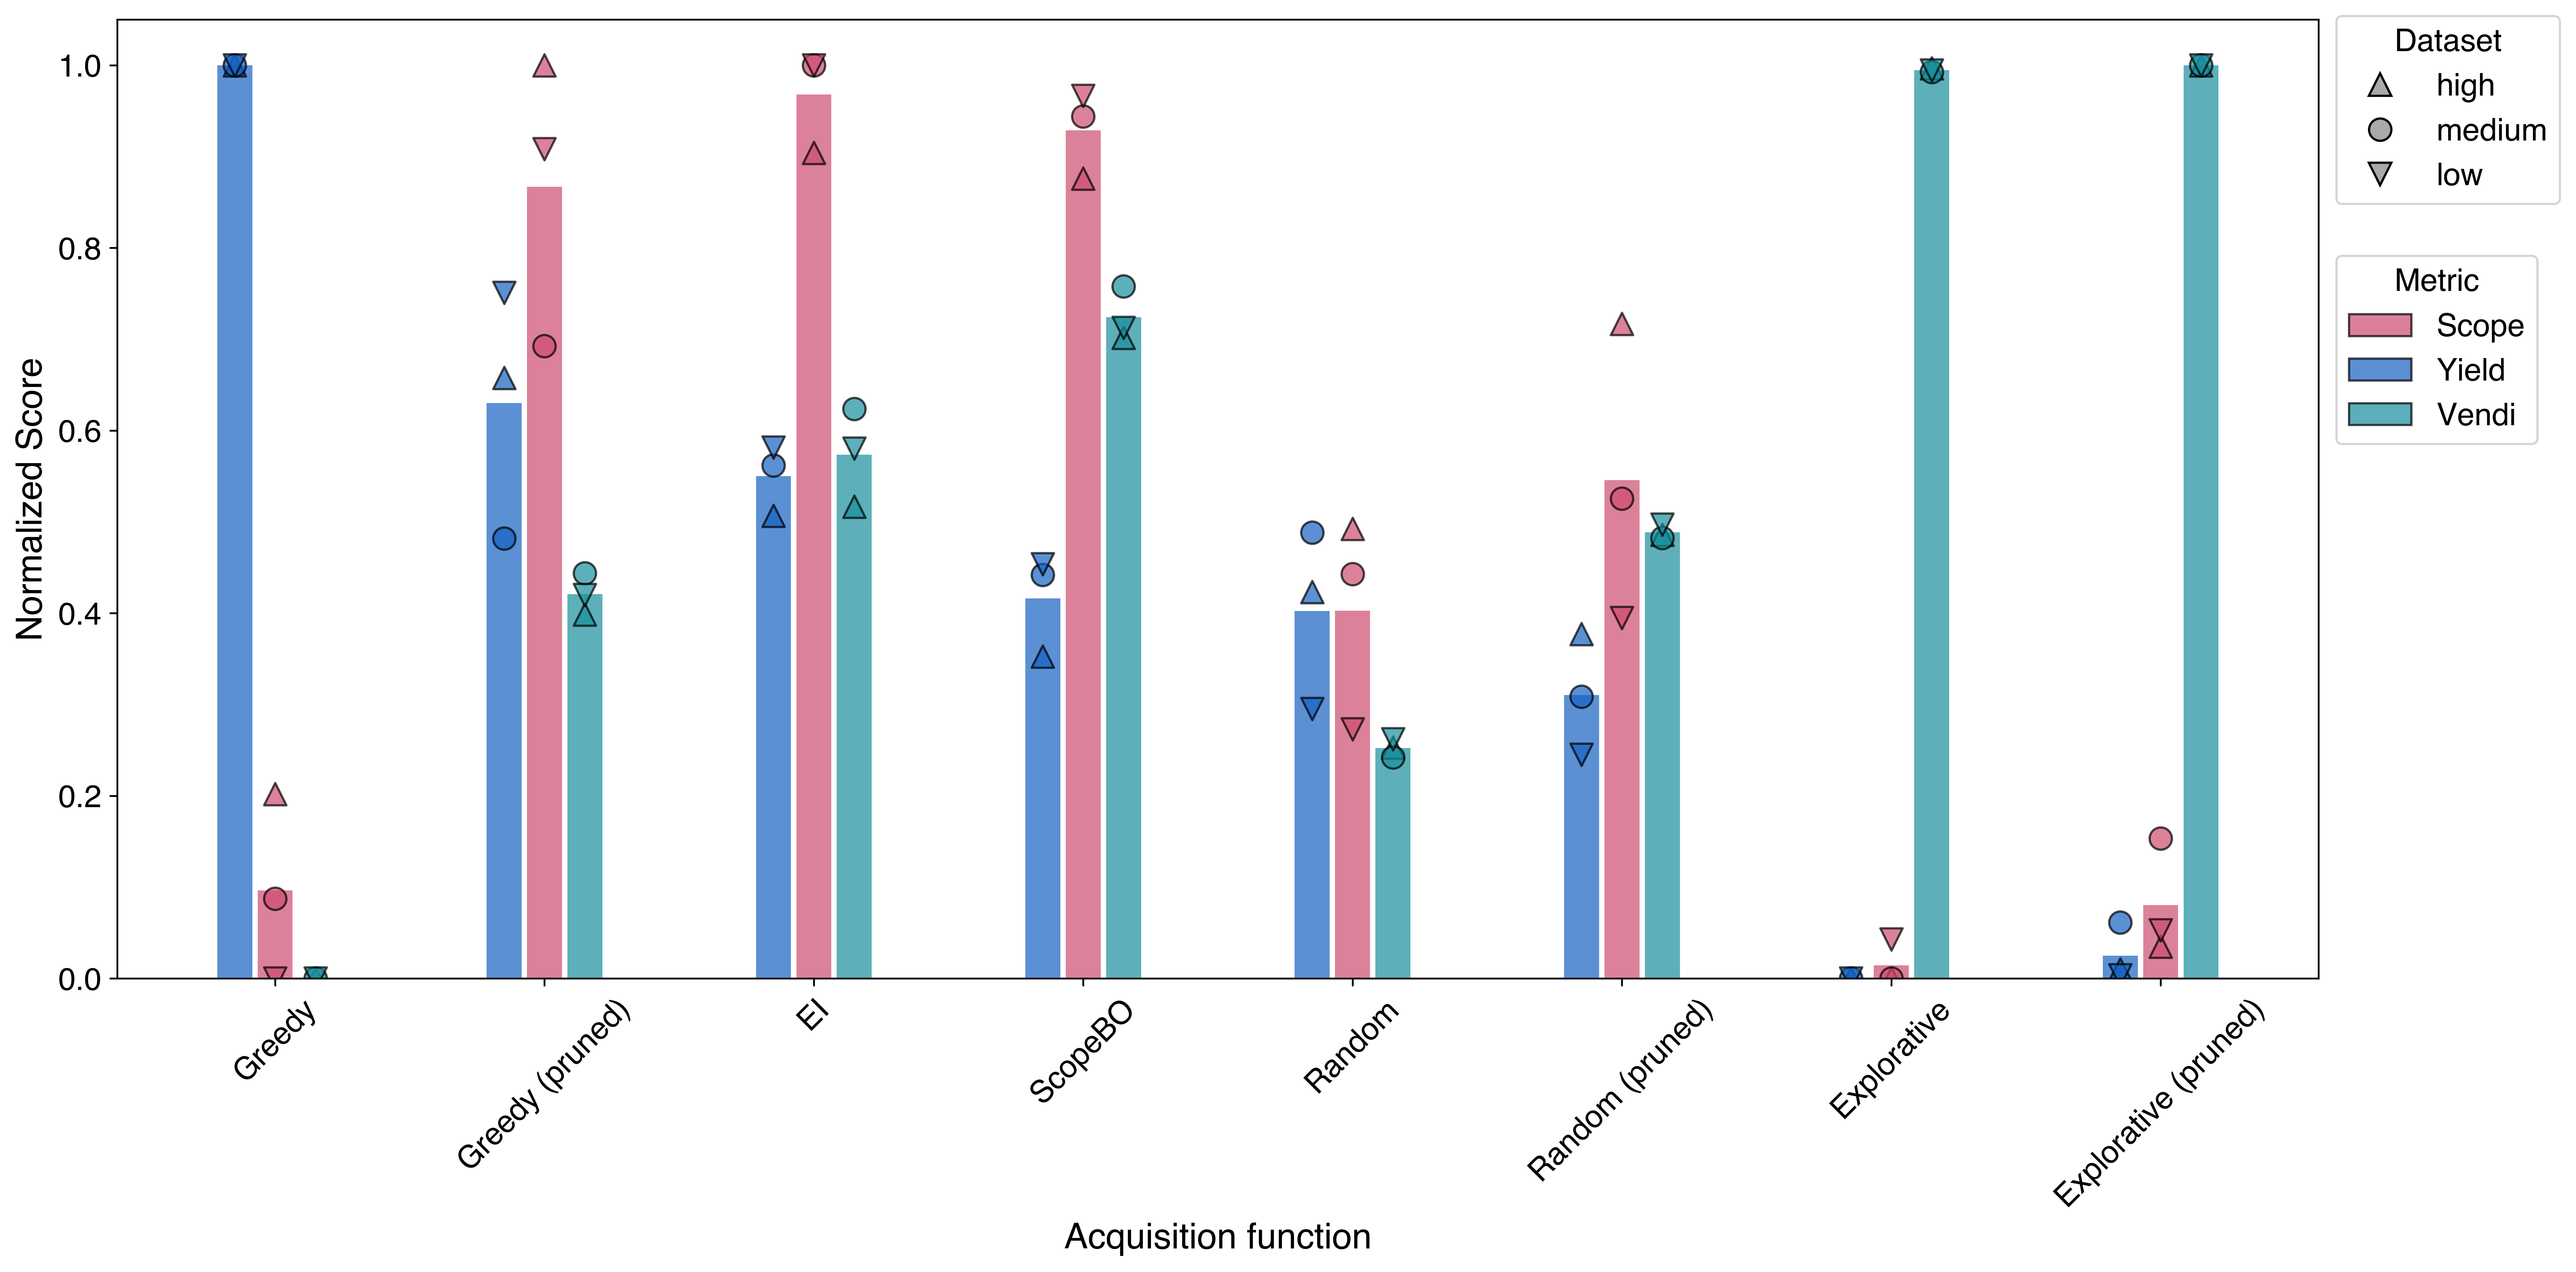

In [9]:
# make a summary plot

records = []
for dataset_name, df in final_scopes.items():
    for idx in df.index:
        for metric in df.columns:
            records.append({
                'Dataset': dataset_name,
                "Acq. Fct.": metric,
                "Metric": idx,
                'Score': df.loc[idx, metric]
            })

long_df = pd.DataFrame(records)
shift = 0.15
offsets = {'Scope': 0, 'Yield': -shift, 'Vendi': shift}
long_df['XOffset'] = long_df["Metric"].map(offsets)

# Positions for each metric
metrics = list(final_scopes["high"].columns)
x_pos_map = {metric: i for i, metric in enumerate(metrics)}
long_df['XBase'] = long_df["Acq. Fct."].map(x_pos_map)
long_df['X'] = long_df['XBase'] + long_df['XOffset']

# Plotting
plt.figure(figsize=(16, 8),dpi=600)
markers = {'high': '^', 'medium': 'o', 'low': 'v'}
colors = {'Scope': all_colors[0], 'Yield': all_colors[1], 'Vendi': all_colors[2]}

# Plot each combination of metric and dataset
for dataset in final_scopes.keys():
    for idx in final_scopes["high"].index:
        subset = long_df[(long_df['Dataset'] == dataset) & (long_df["Metric"] == idx)]
        plt.scatter(
            subset['X'], 
            subset['Score'], 
            marker=markers[dataset],
            color=colors[idx],
            s=100,
            edgecolor='k',
            linewidths=1,
            alpha=0.7
        )

# Legend for Dataset (marker styles)
dataset_legend = [
    Line2D([0], [0], marker=markers[name], color='w', label=name,
           markerfacecolor=all_colors[6], markeredgecolor='k', markersize=10)
    for name in markers
]

# Legend for metric (square patches)
index_legend = [
    Patch(facecolor=colors[name], edgecolor='k', label=name, alpha = 0.7)
    for name in colors
]

# Add the legends
legend1 = plt.legend(handles=dataset_legend, title='Dataset', loc='upper left', bbox_to_anchor=(1.001, 1.02))
legend2 = plt.legend(handles=index_legend, title='Metric', loc='upper left', bbox_to_anchor=(1.001, 0.77))

plt.gca().add_artist(legend1)  # Add the first legend back after second one replaces it

# --- Axis and Title ---
plt.xticks(ticks=range(len(metrics)), labels=metrics,rotation=45)
plt.ylabel('Normalized Score')


# --- Compute mean score per Metric–Index pair across datasets ---
avg_scores = (
    long_df
    .groupby(["Acq. Fct.", "Metric"], as_index=False)['Score']
    .mean()
)

# Map back to X positions using the same offset logic
avg_scores['XBase'] = avg_scores["Acq. Fct."].map(x_pos_map)
avg_scores['XOffset'] = avg_scores["Metric"].map(offsets)
avg_scores['X'] = avg_scores['XBase'] + avg_scores['XOffset']

# --- Add barplot of averages ---
bar_width = 0.13  # adjust width if bars overlap too much
for idx, color in colors.items():
    subset = avg_scores[avg_scores["Metric"] == idx]
    plt.bar(
        subset['X'], 
        subset['Score'], 
        width=bar_width, 
        color=color, 
        alpha=0.7, 
        label=f'{idx} avg', zorder = 0
    )

plt.xlabel("Acquisition function")

plt.tight_layout()
plt.show()

In [10]:
print("Averaged normalized scope scores:")
avg_scores.sort_values(by="Score",inplace=True,ascending=False)
avg_scores.loc[avg_scores["Metric"]=="Scope"][["Acq. Fct.","Score"]]

Averaged normalized scope scores:


Acq. Fct.     Score
0                     EI  0.968065
21               ScopeBO  0.928792
12       Greedy (pruned)  0.866835
18       Random (pruned)  0.545661
15                Random  0.402652
9                 Greedy  0.096477
6   Explorative (pruned)  0.080349
3            Explorative  0.014321

ScopeBO shows decent performance compared to other acquisition functions, but performs continously slightly worse than the EI baseline.

### Comparison between substrate and product descriptors

In [11]:
# compare the final average yields for ScopeBO using either product or substrate features
yield_comparison = pd.DataFrame(np.nan,index=datasets,columns=["Subs","Prods"])
for dset in datasets:
    for feat in ["Subs","Prods"]:
        feat_label = ""  # no subfolder for substrate featurization
        if feat == "Prods":
            feat_label = "Prod_Feat/"
        dfs_progress = Benchmark().progress_plot(budget=27, type_results= "Objective",
                                                name_results=f"Results_Data/{feat_label}{dset}-dataset"\
                                                    f"/ei_with-pruning",
                                                bounds=get_bounds(dset),show_plot=False)
        yield_comparison.loc[dset,feat] = dfs_progress["means"].loc[27,"b3_V13"]
print("Final average yields using different reaction partners for the featurization:")
yield_comparison.applymap(lambda x: f"{x*100:.1f} %")

Final average yields using different reaction partners for the featurization:


Subs   Prods
high    59.6 %  60.8 %
medium  37.5 %  39.4 %
low     21.8 %  23.7 %

The product descriptors yield slightly higher average yields.

To compare the featurization of the scope using descriptors of the substrates or descriptors of the products, we can recalculate the Vendi scores obtained in the scopes using the respective other featurization.

In [ ]:
# relabel the substrate descriptors with the corresponding product smiles
for dset in datasets:
    # load the dataset featurization using the substrate dft features
    feat_subs = pd.read_csv(f"./../Amide_data/Datasets/amide_dset_dft_subs_{dset}-yielding.csv",index_col=0,header=0)
    feat_subs_conv = feat_subs.copy(deep=True)
    # load a df containing the product smiles and the smiles for the corresponding substrate combinations
    conv = pd.read_csv(f"./../Amide_data/Datasets/Descriptor_Generation/amide_smiles_products_filtered.csv",
                        names=["Products","Combinations"])
    # reassign the index to be the product smiles instead of the substrate combination smiles
    feat_subs_conv.index = [conv.loc[conv["Combinations"]==smiles,"Products"].values[0] for smiles in feat_subs.index]
    # save the new featurization (substrate features with product smiles indices)
    feat_subs_conv.to_csv(f"./Results_Data/Prod_Feat/Subs_vs_Prods_Feat/subs-dft-feat_prod-idx_{dset}-yielding.csv")

In [13]:
# relabel the product descriptors with the corresponding substrate combination smiles
for dset in datasets:
    # load the dataset featurization using the substrate dft features
    feat_prod = pd.read_csv(f"./../Amide_data/Datasets/amide_dset_dft_prod_{dset}-yielding.csv",index_col=0,header=0)
    feat_prod_conv = feat_prod.copy(deep=True)
    # load a df containing the product smiles and the smiels for the corresponding substrate combinations
    conv = pd.read_csv(f"./../Amide_data/Datasets/Descriptor_Generation/amide_smiles_products_filtered.csv",
                        names=["Products","Combinations"])
    # reassign the index to be the product smiles instead of the substrate combination smiles
    feat_prod_conv.index = [conv.loc[conv["Products"]==smiles,"Combinations"].values[0] for smiles in feat_prod.index]
    # save the new featurization (substrate features with product smiles indices)
    feat_prod_conv.to_csv(f"./Results_Data/Prod_Feat/Subs_vs_Prods_Feat/prod-dft-feat_subs-idx_{dset}-yielding.csv")

In [14]:
# # copy the data for the ScopeBo runs with substrate and product featurization to the same location
# for dset in datasets:
#     src_dir1 = f"./Results_Data/Prod_Feat/{dset}-dataset/ei_with-pruning"
#     trg_dir1 = f"./Results_Data/Prod_Feat/Subs_vs_Prods_Feat/prod_feat_{dset}"
#     shutil.copytree(src_dir1, trg_dir1)
#     src_dir2 = f"./Results_Data/{dset}-dataset/ei_with-pruning"
#     trg_dir2 = f"./Results_Data/Prod_Feat/Subs_vs_Prods_Feat/subs_feat_{dset}"
#     shutil.copytree(src_dir2, trg_dir2)

In [15]:
# # recalculate the Vendi scores using the product featurization for that the scopes selected by substrate featurization
# for i,dset in enumerate(datasets):
#     Benchmark().change_featurization(name_feat = "subs",
#                                     name_results=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/prod_feat_{dset}",
#                                     filename_labelled=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/subs-dft-feat_prod-idx_{dset}-yielding.csv",
#                                     directory=".")

In [16]:
# # recalculate the Vendi scores using the product featurization for that the scopes selected by substrate featurization
# for i,dset in enumerate(datasets):
#     Benchmark().change_featurization(name_feat = "prod",
#                                     name_results=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/subs_feat_{dset}",
#                                     filename_labelled=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/prod-dft-feat_subs-idx_{dset}-yielding.csv",
#                                     directory=".")

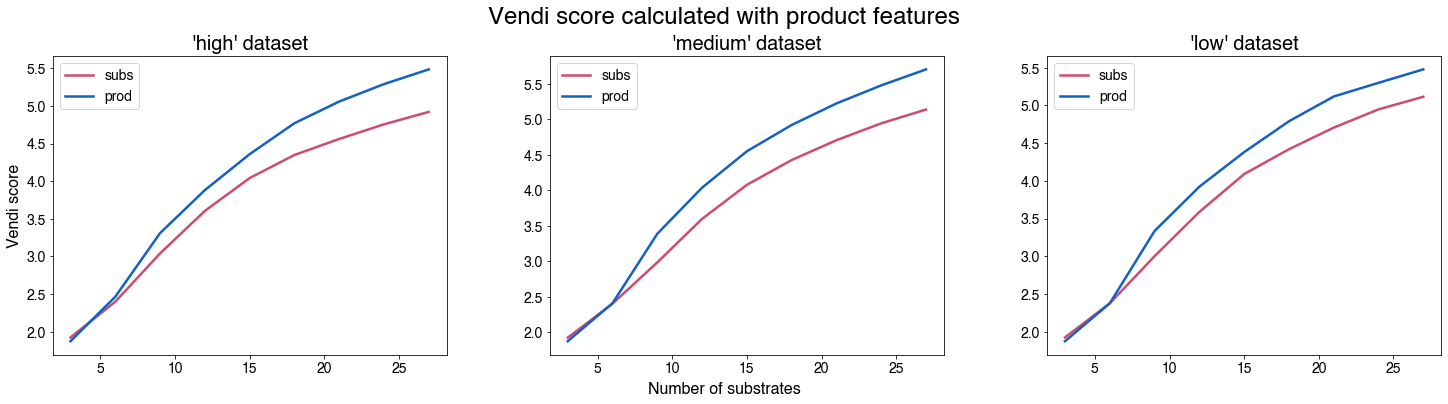

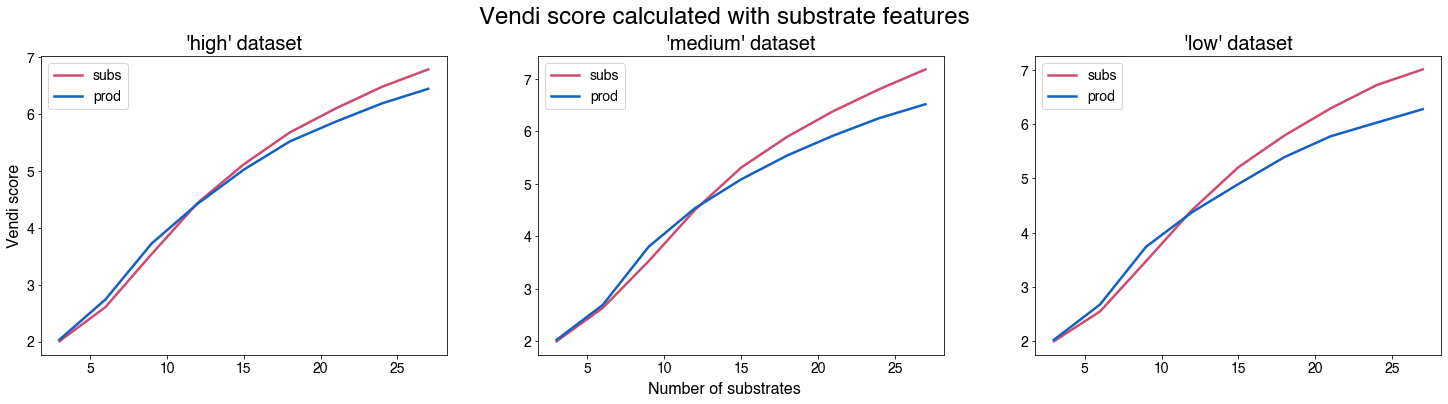

In [17]:
type_results = "Vendi"

analysis_feat = {"calculated with product features": "prod",
                 "calculated with substrate features": "subs",
                 }
feat_list = ["subs","prod"]

final_scores = {}

scores = {}



for an_feat in analysis_feat.keys():

    fig, axes = plt.subplots(1, 3, figsize=(20, 5.5), constrained_layout=True, gridspec_kw={"wspace":0.16})

    fig.suptitle(f"{type_results} score {an_feat}")

    scores_an_feat = pd.DataFrame(np.nan,index=feat_list,columns=datasets)

    for i,dset in enumerate(datasets):

        # To store the legend handles and labels
        handles, labels = [], []

        dfs = {}
        for feat in feat_list:
            feat_label = f"{feat}_feat_{dset}"

            label = f"{feat_label}_{analysis_feat[an_feat]}_feat"
            if feat == analysis_feat[an_feat]:
                label = feat_label

            dfs_progress = Benchmark().progress_plot(
                budget=27, 
                type_results=type_results,
                name_results=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/{label}",
                bounds=get_bounds(dset), 
                show_plot=False
            )
            dfs[feat] = dfs_progress["means"]

            scores_an_feat.loc[feat,an_feat] = dfs[feat].loc[27,"b3_V13"]

        df_combined = pd.concat(dfs, axis=1)
        df_combined.columns = [multiindex[0] for multiindex in df_combined.columns]
        
        for j,col in enumerate(df_combined.columns):
            style = '-' if j <= 6 else '--' if j <= 13 else ':'
            plotting = df_combined[col][df_combined[col].notna()]
            axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)
        axes[i].set_title(f"'{dset}' dataset")
        axes[i].legend()
    axes[0].set_ylabel("Vendi score")
    fig.supxlabel("Number of substrates",fontsize=16)
    plt.show()

Both featurizations are preferred when they are used in the Vendi score calculation. To further differentiate the two options, we calculated the Vendi scores using orthogonal similarity metrics for the generation of the underlying covariance matrix:
* Average covariance of the substrate combination/ product featurization (calculated as geometric mean)
* Tanimoto similarity of the RdKit fingerprints (for both the substrates and products)
* Tanimoto similarity of the Morgan2 fingerprints (for both the substrates and products)

In [18]:
# calculate an average similarity matrix by taking the geometric mean 
# of the covariance matrices for all the different acquisition functions
dict_cov_mat = {}
# NOTE: obtain_full_covar_matrix automatically sorts the dataframes by index so that the 
# indexing between the different cov mat will be consistent
# NOTE: as the substrates are the same for all datasets, the cov mat only needs to be 
# calculated once for one of the datasets
dict_cov_mat["subs"] = obtain_full_covar_matrix(objectives=["yield"],directory=".",
                                filename=f"./../Amide_data/Datasets/amide_dset_dft_subs_high-yielding.csv")
# NOTE: for the products, we use the product featurization with the substrate 
# combination smiles as indices (generated above)
dict_cov_mat["prod"] = obtain_full_covar_matrix(objectives=["yield"],directory=".",
                                filename=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat"\
                                    "/prod-dft-feat_subs-idx_high-yielding.csv")

In [19]:
# calculate geometic mean
stacked = np.stack([mat.values for mat in dict_cov_mat.values()])
# replace zero values in the covariance matrices with a small jitter 
stacked = np.where(stacked == 0, 1e-16, stacked)
geom_mean = np.exp(np.mean(np.log(stacked),axis=0))
# convert to df
av_cov_mat = pd.DataFrame(geom_mean)

In [20]:
# # recalculate the Vendi scores using averaged covariance matrix for the scopes selected by substrate featurization
# for i,dset in enumerate(datasets):
#     # NOTE: The labelled data with the DFT features is required to assign the samples but the featurization is NOT used.
#     Benchmark().change_featurization(name_feat = "av-cov",
#                                 name_results=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/subs_feat_{dset}",
#                                 filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_subs_high-yielding.csv",
#                                 directory=".",
#                                 cov_mat = av_cov_mat)

In [21]:
# recalculate the Vendi scores using averaged covariance matrix for the scopes selected by product featurization

# as the av_cov is sorted according to the sorted substrate combination indices, but the results here contain product feat,
# we need to reorder the av_cov to match the sorted product indices in order to use the matrix for Vendi score recalculation

# write a function for that problem so that it can be reused later
def cov_mat_conversion(cov_mat,orig_feat,name_orig,conv):
    """Convert the covariance matrix sorting from subs/prods alignment to the other one."""
    cov_mat_new = cov_mat.copy(deep=True)
    # add the original index smiles and replace them with the corresponding smiles of the other featurization
    name_new = None
    if name_orig == "Combinations":
        name_new = "Products"
    elif name_orig == "Products":
        name_new = "Combinations"
    cov_mat_new.index = [conv.loc[conv[name_orig]== smiles,name_new].values[0] 
                            for smiles in orig_feat.index.sort_values().to_list()]
    cov_mat_new.columns = [conv.loc[conv[name_orig]== smiles, name_new].values[0] 
                            for smiles in orig_feat.index.sort_values().to_list()]
    # sort the columns and indices
    cov_mat_new.sort_index(axis=0, inplace=True)
    cov_mat_new.sort_index(axis=1, inplace=True)
    # reset the index to numerical
    cov_mat_new.reset_index(drop=True,inplace=True)
    cov_mat_new.columns = cov_mat_new.index

    return cov_mat_new

In [22]:
# # resort the av_cov_mat (sorted according to subs combi) with the product smiles
# av_cov_mat_prod = cov_mat_conversion(cov_mat = av_cov_mat, orig_feat = feat_subs, name_orig = "Combinations", conv = conv)

# for i,dset in enumerate(datasets):
#     Benchmark().change_featurization(name_feat = "av-cov",
#                                 name_results=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/prod_feat_{dset}",
#                                 filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_prod_high-yielding.csv",
#                                 directory=".",
#                                 cov_mat = av_cov_mat_prod)

Calculate the Vendi score based on the pairwise Tanimoto similarities of either the RDKit fingerprints or the Morgan2 fingerprints. We calculate these Vendi scores as the geometric average of the respective substrate combination and product similarities.

Let's start with the Tanimoto similarities of the RDKit fingerprints.

In [23]:
# get smiles lists for the products and substrate combinations (both in the order of the sorted substrate smiles)
smiles_subs = feat_subs.index.sort_values().to_list()
smiles_prods = [conv.loc[conv["Combinations"] == smiles, "Products"].values[0] for smiles in smiles_subs]

# convert to mols
mols_subs = [Chem.MolFromSmiles(smiles) for smiles in smiles_subs]
mols_prods = [Chem.MolFromSmiles(smiles) for smiles in smiles_prods]

def tanimoto_sim(mols_subs,mols_prods,name_fingerprint):

    # instantiate fingerprint generator
    fpg = None
    if name_fingerprint.lower() == "rdkit":
        fpg = rdFingerprintGenerator.GetRDKitFPGenerator()
    elif name_fingerprint.lower() == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius = 2)
    # create the fingerprints
    fps_subs = [fpg.GetFingerprint(mol) for mol in mols_subs]
    fps_prods = [fpg.GetFingerprint(mol) for mol in mols_prods]

    def get_tanimoto(fps):
        n = len(fps)
        tanimoto_matrix = np.zeros((n, n))
        for i in range(n):
            sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps)
            tanimoto_matrix[i, :] = sims
        return pd.DataFrame(tanimoto_matrix)

    tanimoto_subs = get_tanimoto(fps_subs)
    tanimoto_prods = get_tanimoto(fps_prods)

    # calculate geometic mean
    stacked = np.stack([tanimoto_subs,tanimoto_prods])
    # replace zero values in the covariance matrices with a small jitter 
    stacked = np.where(stacked == 0, 1e-16, stacked)
    geom_mean = np.exp(np.mean(np.log(stacked),axis=0))
    # convert to df and return
    return pd.DataFrame(geom_mean)

In [24]:
# recalculate the Vendi scores using the tanimoto similarities (rdkit fingerprint)
av_tanimoto_rdk = tanimoto_sim(mols_subs,mols_prods,"rdkit")

# for dset in datasets:
#     # NOTE: The labelled data with the DFT features is required to assign the samples but the featurization is NOT used.
#     Benchmark().change_featurization(name_feat = "tm-rdkit",
#                                 name_results=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/subs_feat_{dset}",
#                                 filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_subs_high-yielding.csv",
#                                 directory=".",
#                                 cov_mat = av_tanimoto_rdk)
    
# re-sort the av_tanimoto_rdk (currently sorted according to subs combi) with the product smiles
av_tanimoto_rdk_prod = cov_mat_conversion(cov_mat = av_tanimoto_rdk, 
                                          orig_feat = feat_subs, 
                                          name_orig = "Combinations", 
                                          conv = conv)

# for dset in datasets:
#     Benchmark().change_featurization(name_feat = "tm-rdkit",
#                                 name_results=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/prod_feat_{dset}",
#                                 filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_prod_high-yielding.csv",
#                                 directory=".",
#                                 cov_mat = av_tanimoto_rdk_prod)

In [25]:
# recalculate the Vendi scores using the tanimoto similarities (rdkit fingerprint)
av_tanimoto_morgan2 = tanimoto_sim(mols_subs,mols_prods,"morgan2")

# for dset in datasets:
#     # NOTE: The labelled data with the DFT features is required to assign the samples but the featurization is NOT used.
#     Benchmark().change_featurization(name_feat = "tm-morgan2",
#                                 name_results=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/subs_feat_{dset}",
#                                 filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_subs_high-yielding.csv",
#                                 directory=".",
#                                 cov_mat = av_tanimoto_morgan2)
    
# re-sort the av_tanimoto_rdk (currently sorted according to subs combi) with the product smiles
av_tanimoto_morgan2_prod = cov_mat_conversion(cov_mat = av_tanimoto_morgan2, 
                                          orig_feat = feat_subs, 
                                          name_orig = "Combinations", 
                                          conv = conv)

# for dset in datasets:
#     Benchmark().change_featurization(name_feat = "tm-morgan2",
#                                 name_results=f"./Results_Data/Prod_feat/Subs_vs_Prods_Feat/prod_feat_{dset}",
#                                 filename_labelled=f"./../Amide_data/Datasets/amide_dset_dft_prod_high-yielding.csv",
#                                 directory=".",
#                                 cov_mat = av_tanimoto_morgan2_prod)

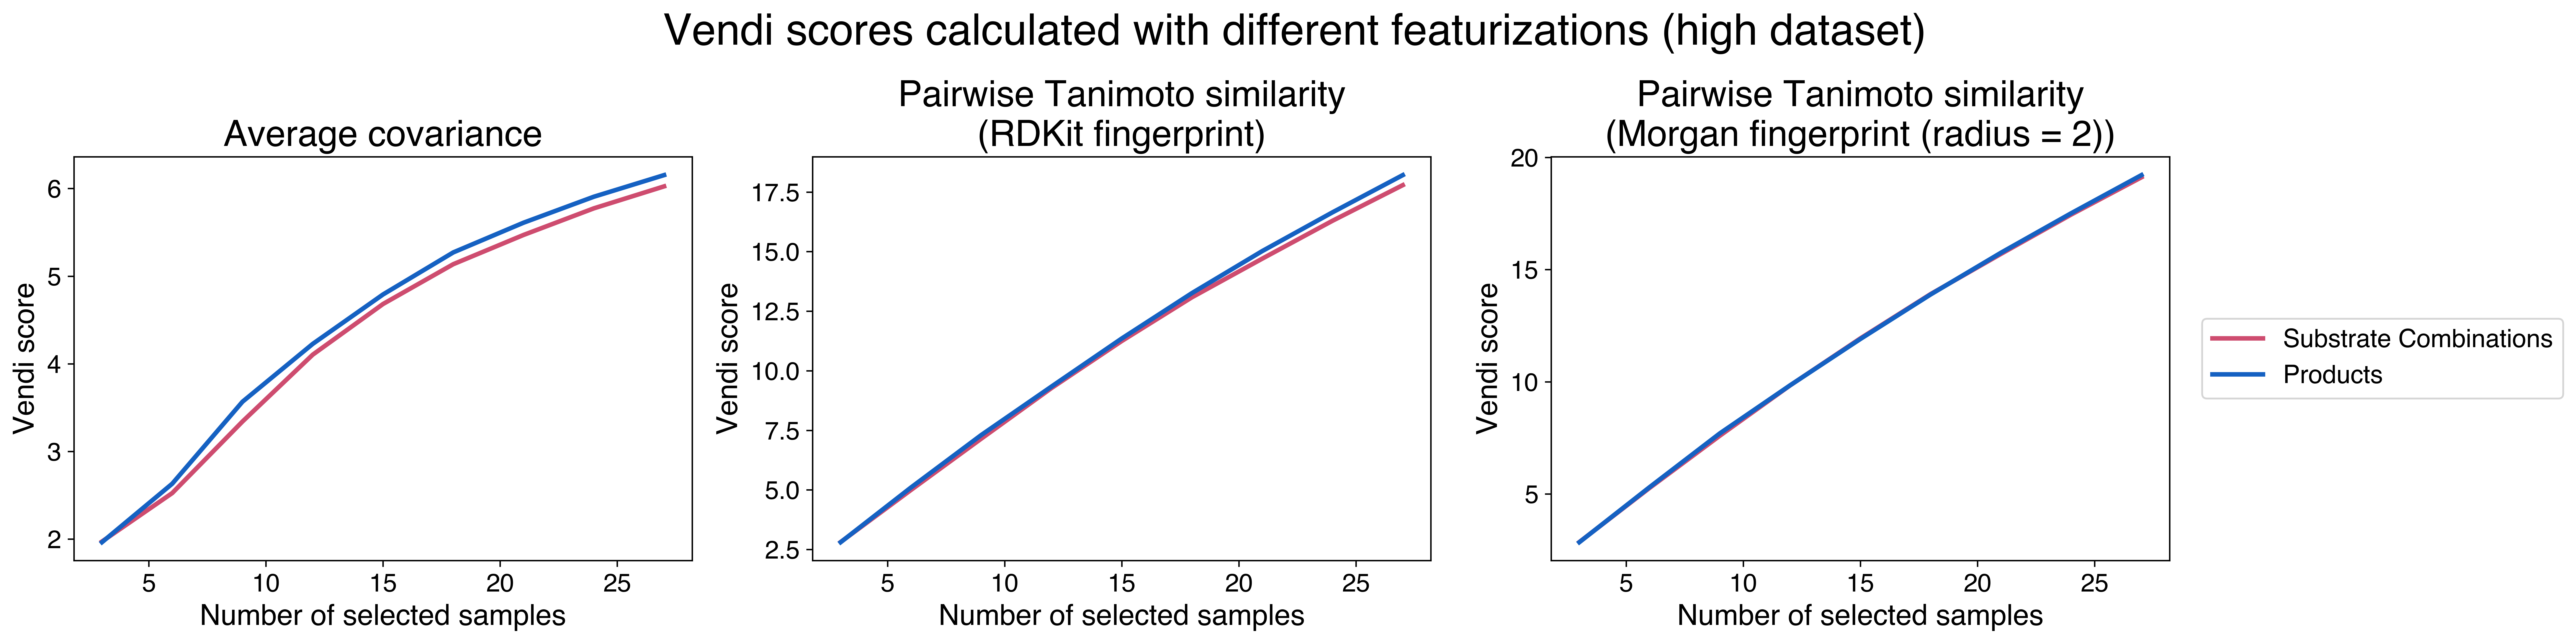

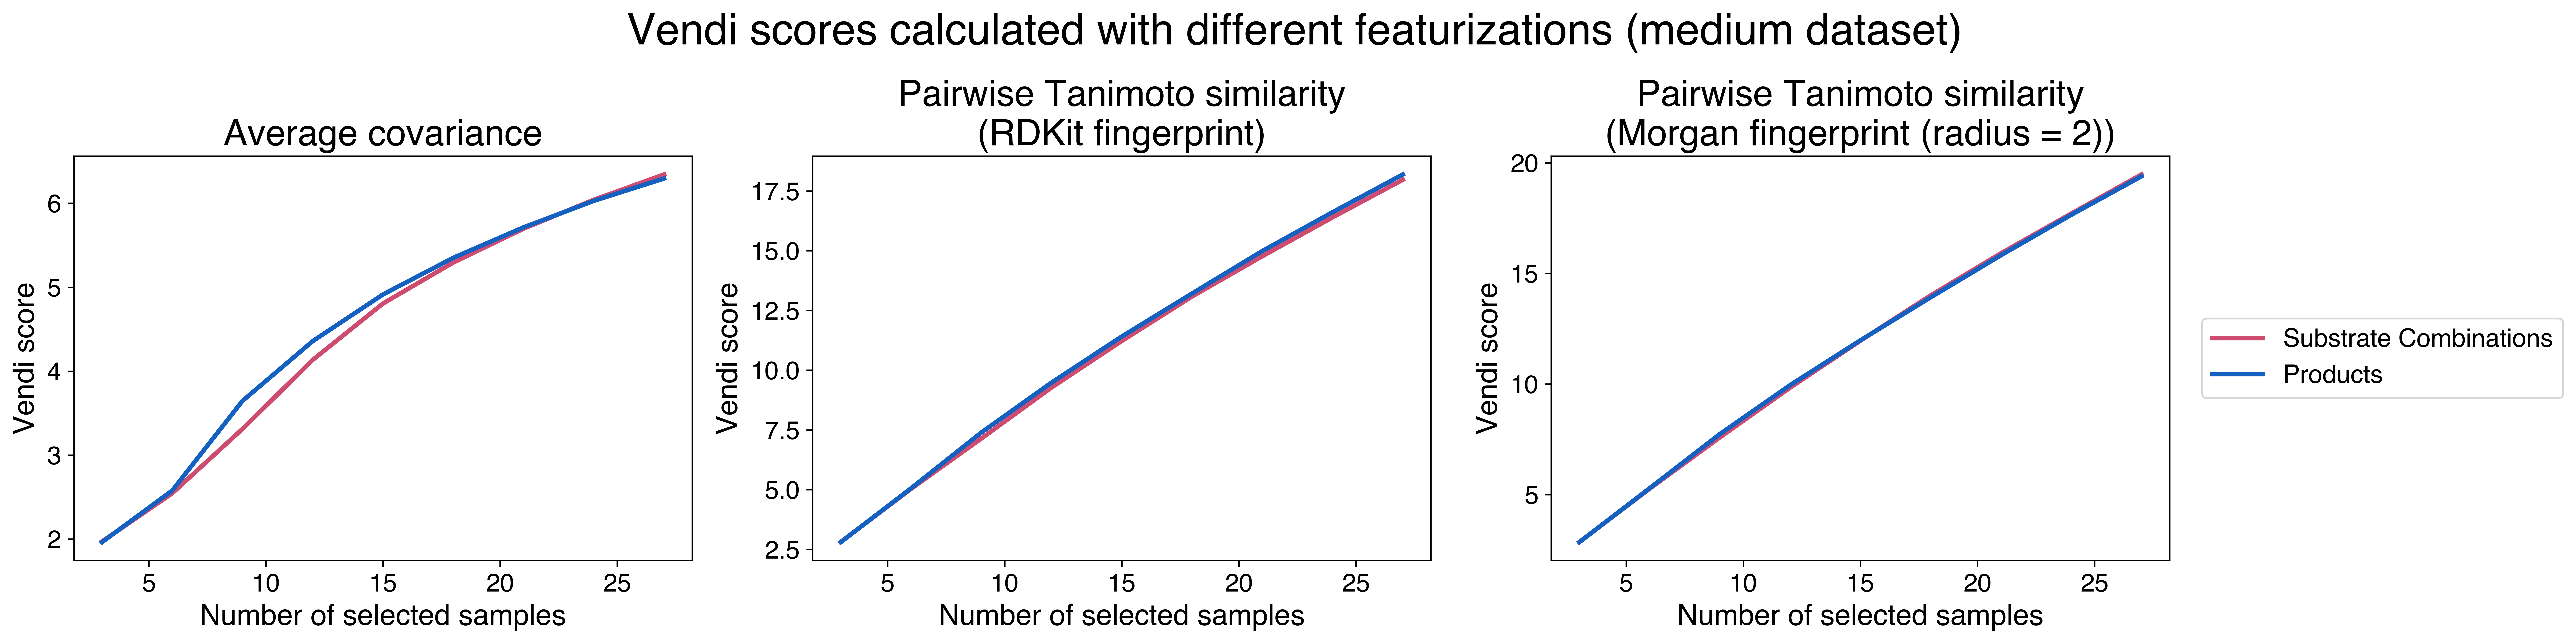

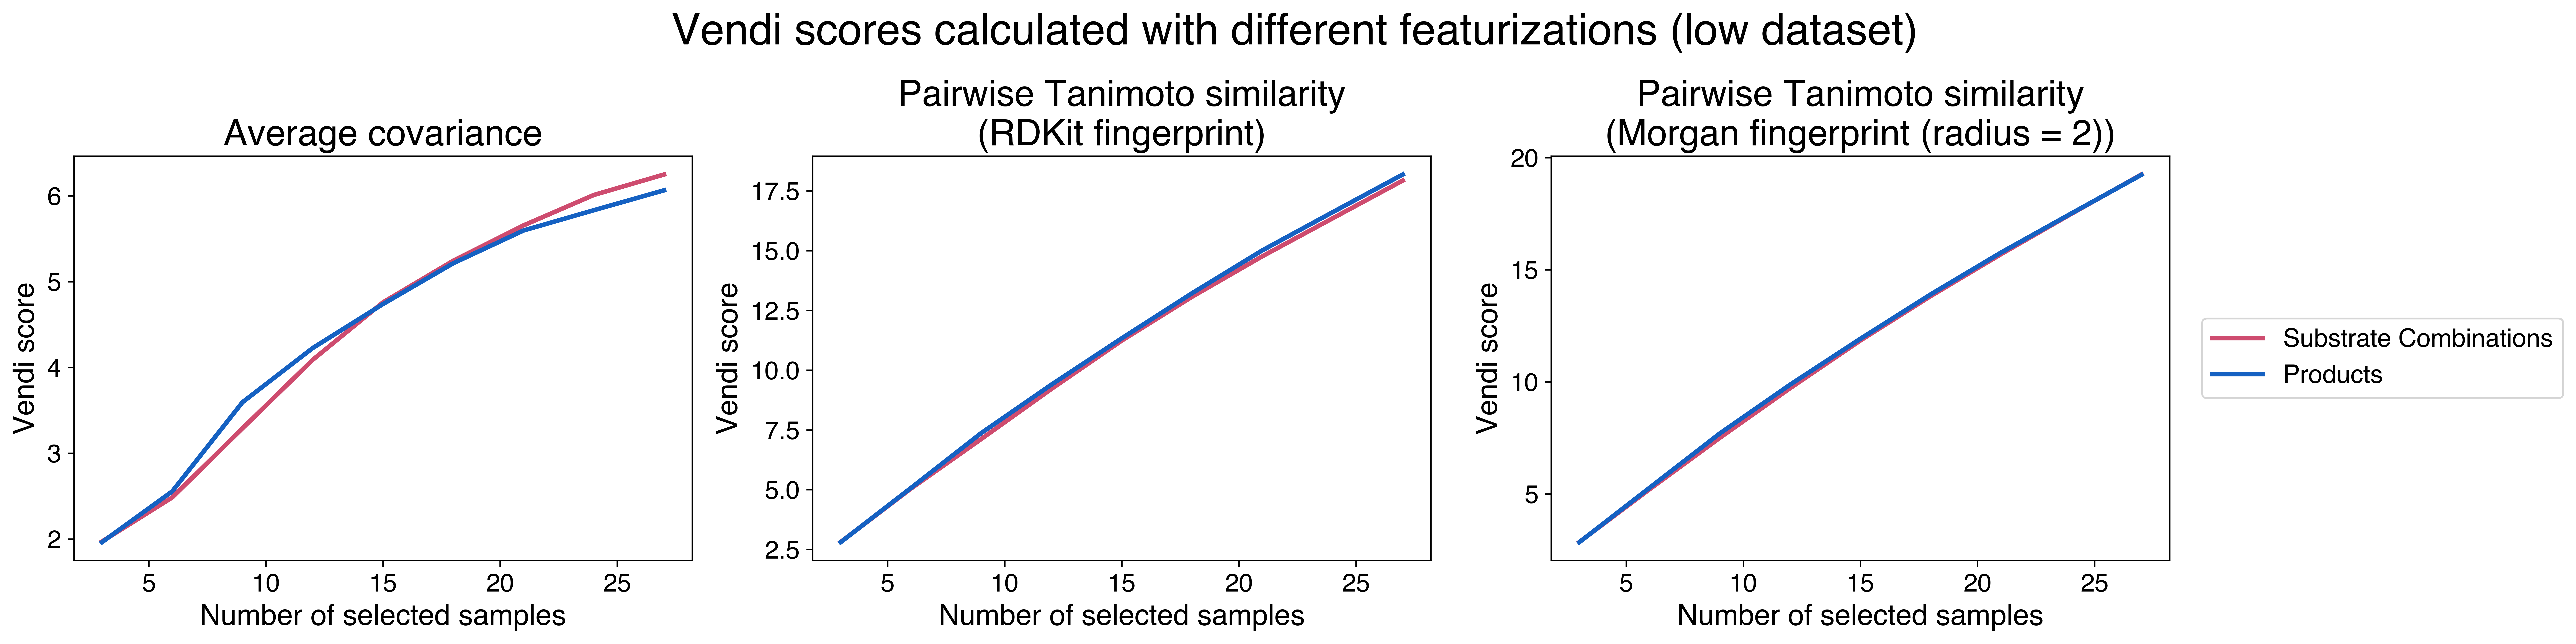

In [26]:
analysis_feat = {"Average covariance": "_av-cov_feat",
                 "Pairwise Tanimoto similarity\n(RDKit fingerprint)": "_tm-rdkit_feat",
                 "Pairwise Tanimoto similarity\n(Morgan fingerprint (radius = 2))": "_tm-morgan2_feat"
                 }
feature_types = {"Products": "prod", "Substrate Combinations": "subs"}
final_scores = {}


for dset in datasets:

    scores_dset = pd.DataFrame(np.nan,index=feature_types.keys(),columns=analysis_feat.keys())

    fig, axes = plt.subplots(1,4, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.3]},dpi=600)
    axes = axes.flatten()

    fig.suptitle(f"Vendi scores calculated with different featurizations ({dset} dataset)", fontsize=24)

    # To store the legend handles and labels
    handles, labels = [], []

    for i, (feat_label, vendi_feat) in enumerate(analysis_feat.items()):

        dfs = {}
        for feat in feature_types.keys():
            dfs_progress = Benchmark().progress_plot(
                budget=27, 
                type_results=type_results,
                name_results=f"./Results_Data/Prod_Feat/Subs_vs_Prods_Feat/{feature_types[feat]}_feat_{dset}{vendi_feat}",
                bounds=get_bounds(dset), 
                show_plot=False
            )
            dfs[feat] = dfs_progress["means"]
            scores_dset.loc[feat,feat_label] = dfs[feat].loc[27,"b3_V13"]

        final_scores[dset] = scores_dset

        df_combined = pd.concat(dfs, axis=1)
        df_combined.columns = [multiindex[0] for multiindex in df_combined.columns]
        
        for j,col in enumerate(df_combined.columns[::-1]):
            style = '-' if j <= 6 else '--' if j <= 13 else ':'
            plotting = df_combined[col][df_combined[col].notna()]
            axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)

        # Collect handles and labels for the legend from the first plot
        if i == 0:
            handles, labels = axes[i].get_legend_handles_labels()

        axes[i].set_xlabel('Number of selected samples')
        axes[i].set_ylabel(f"{type_results} score")
        axes[i].set_title(f"{feat_label}")

    # Add legend to the 6th subplot (empty one)
    axes[3].legend(handles, labels, loc='center')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

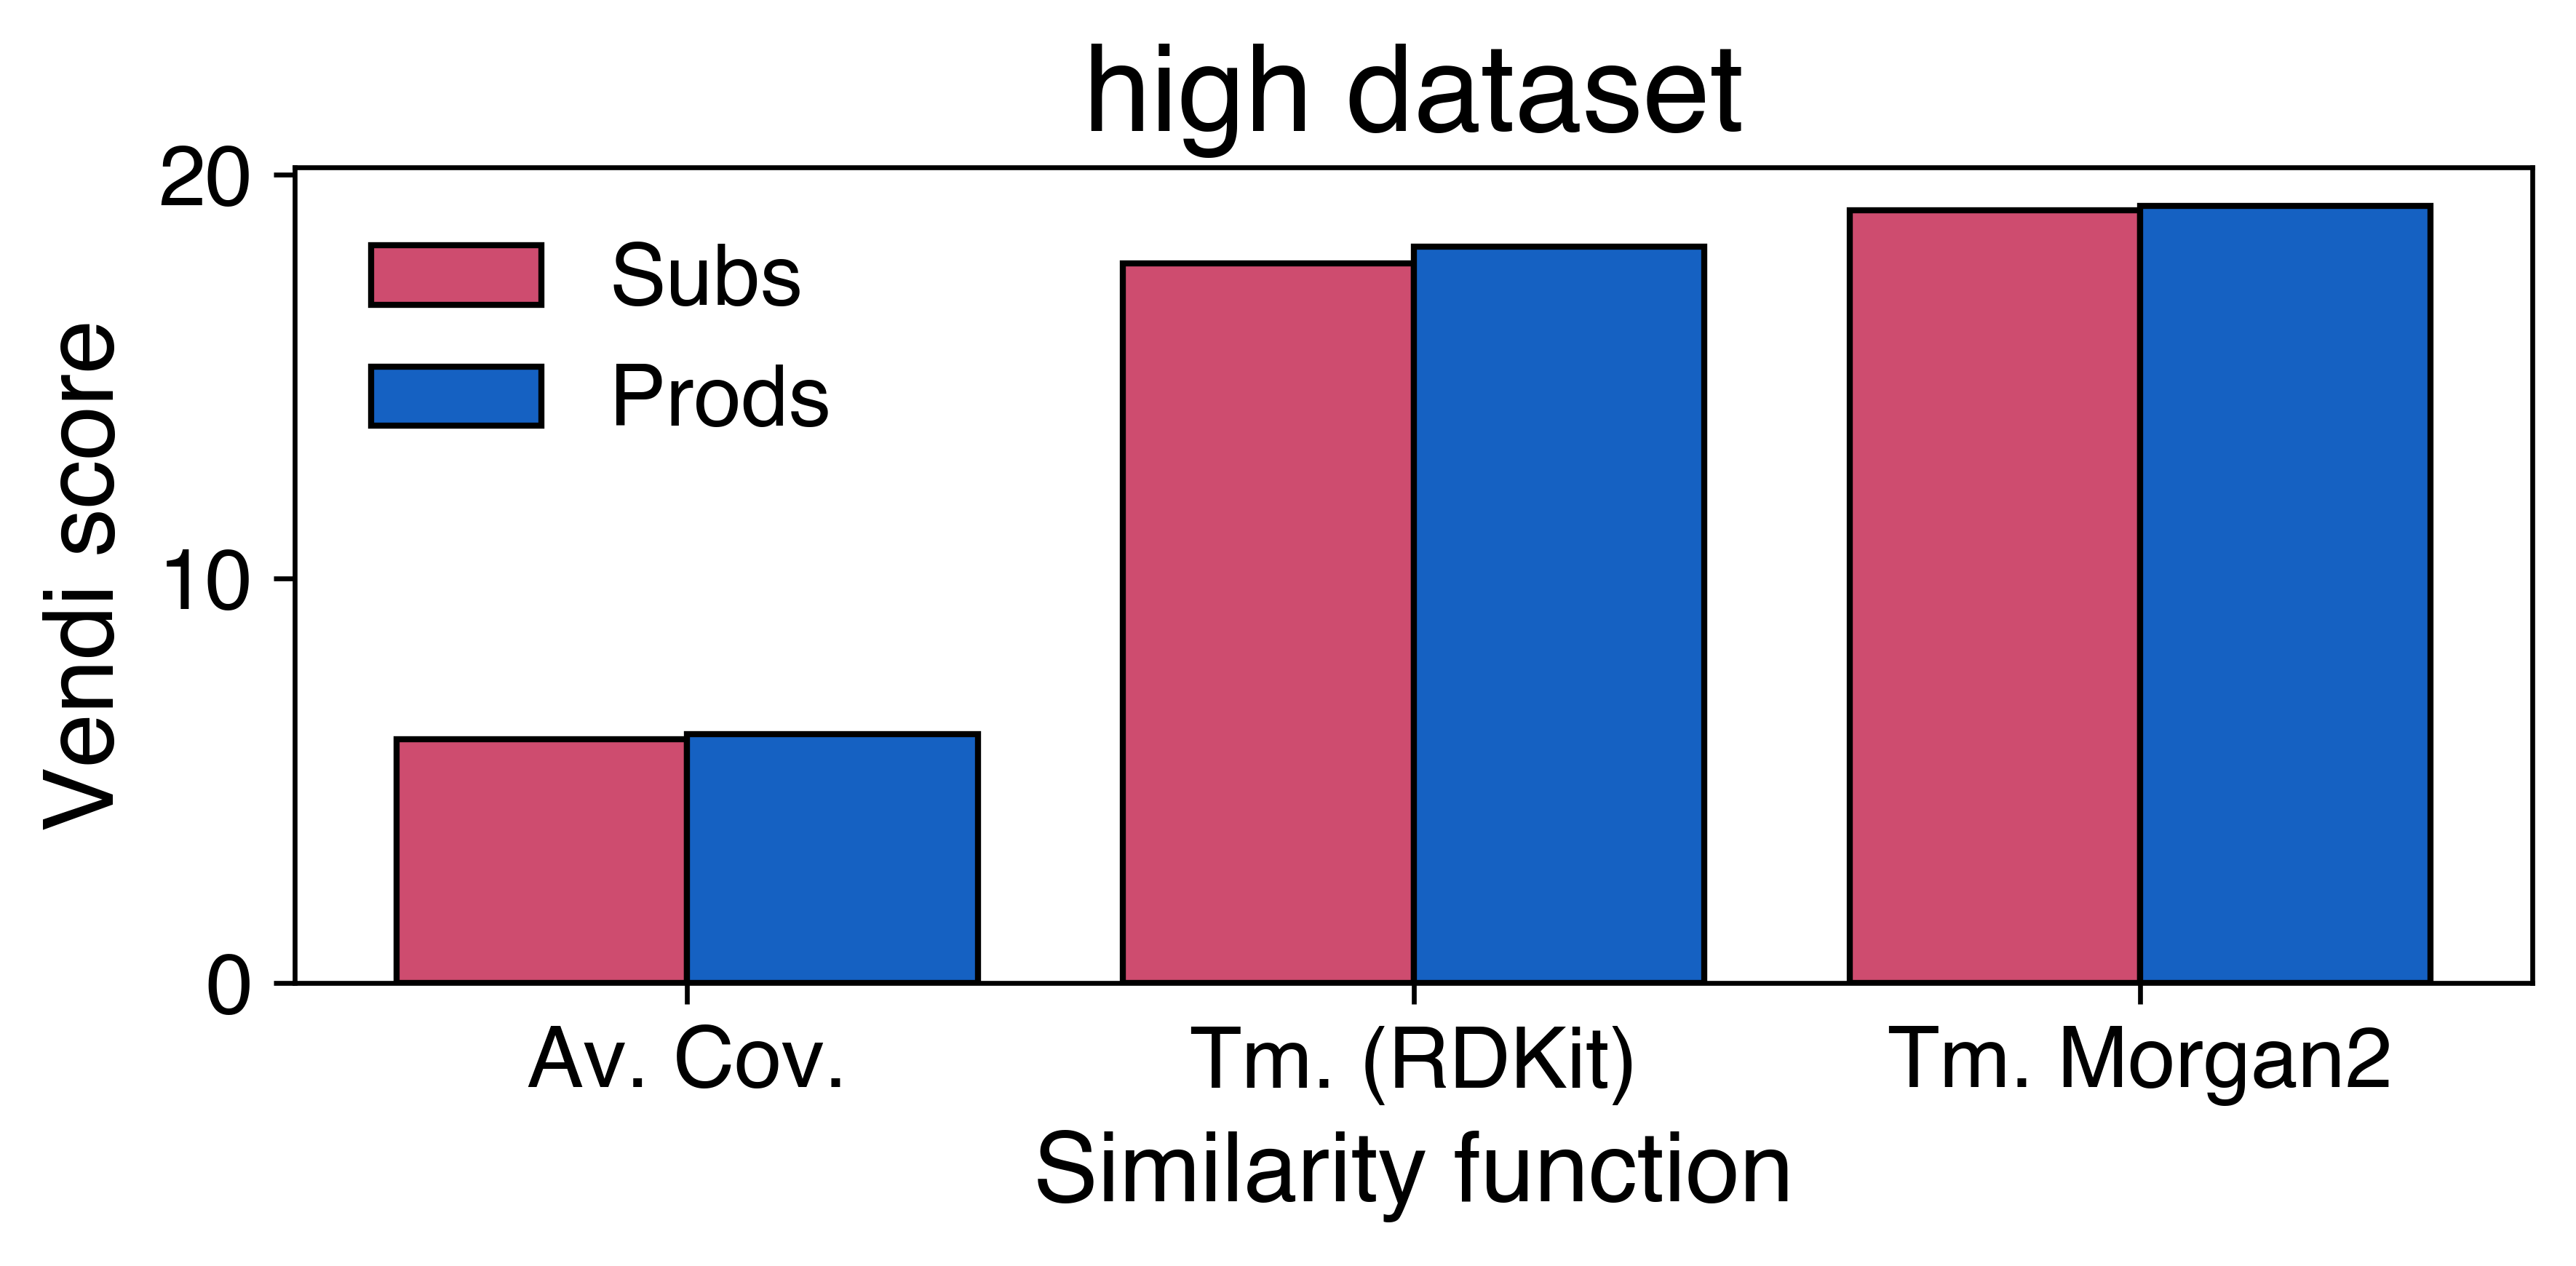

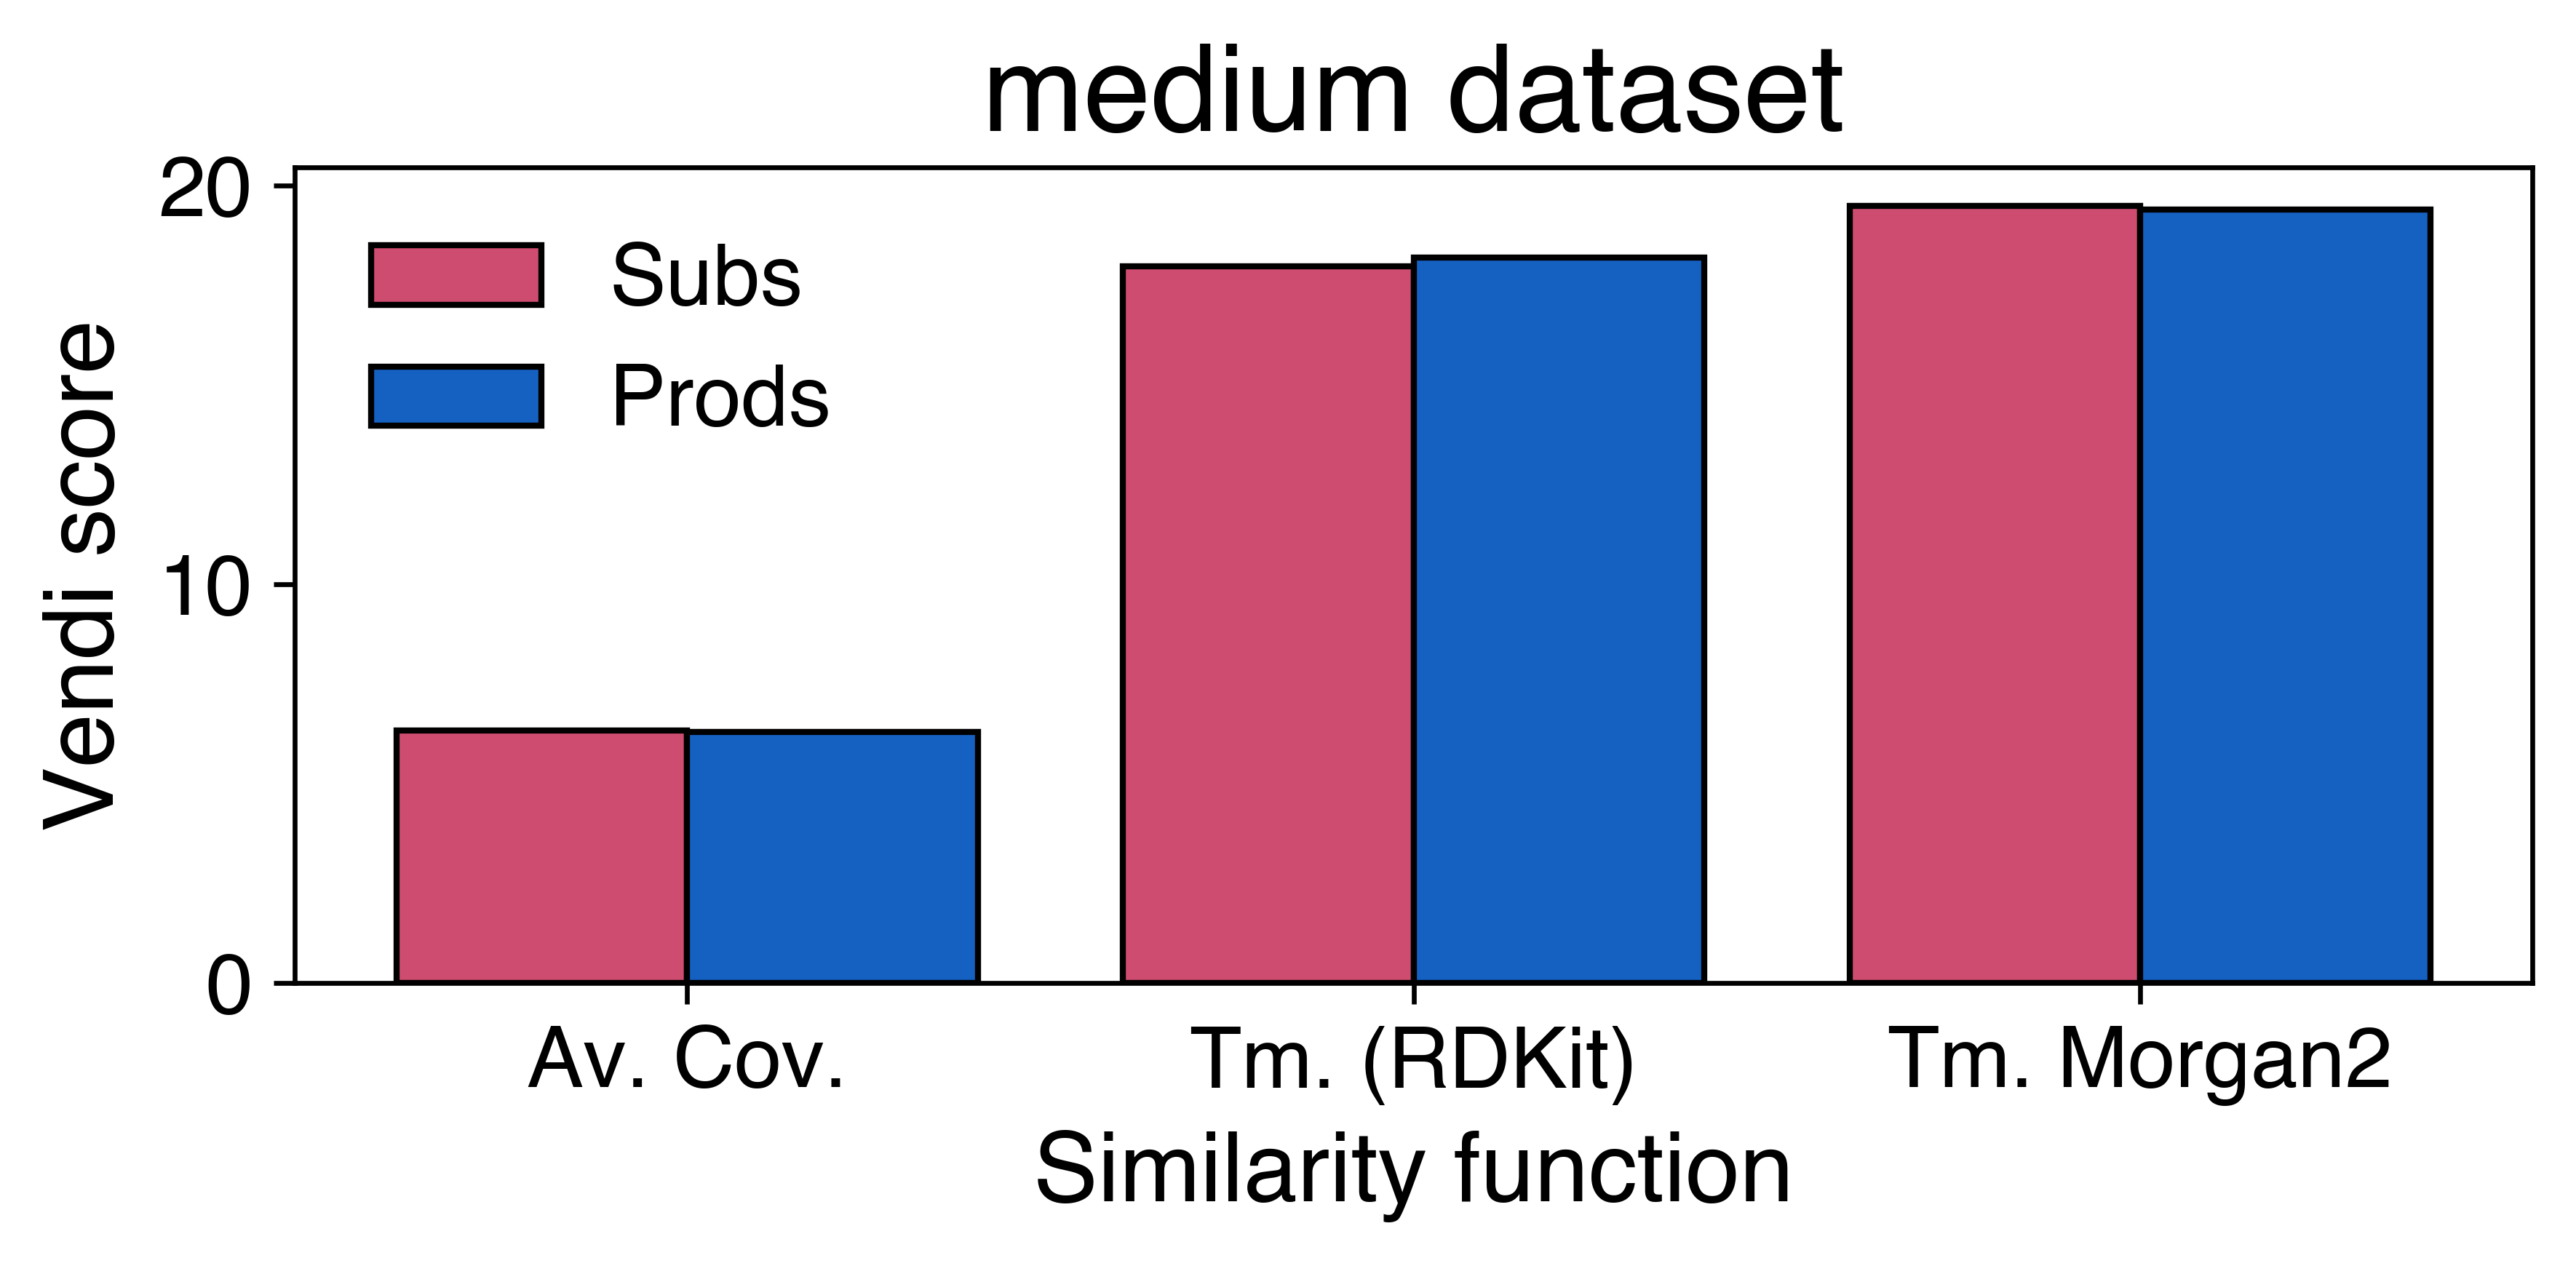

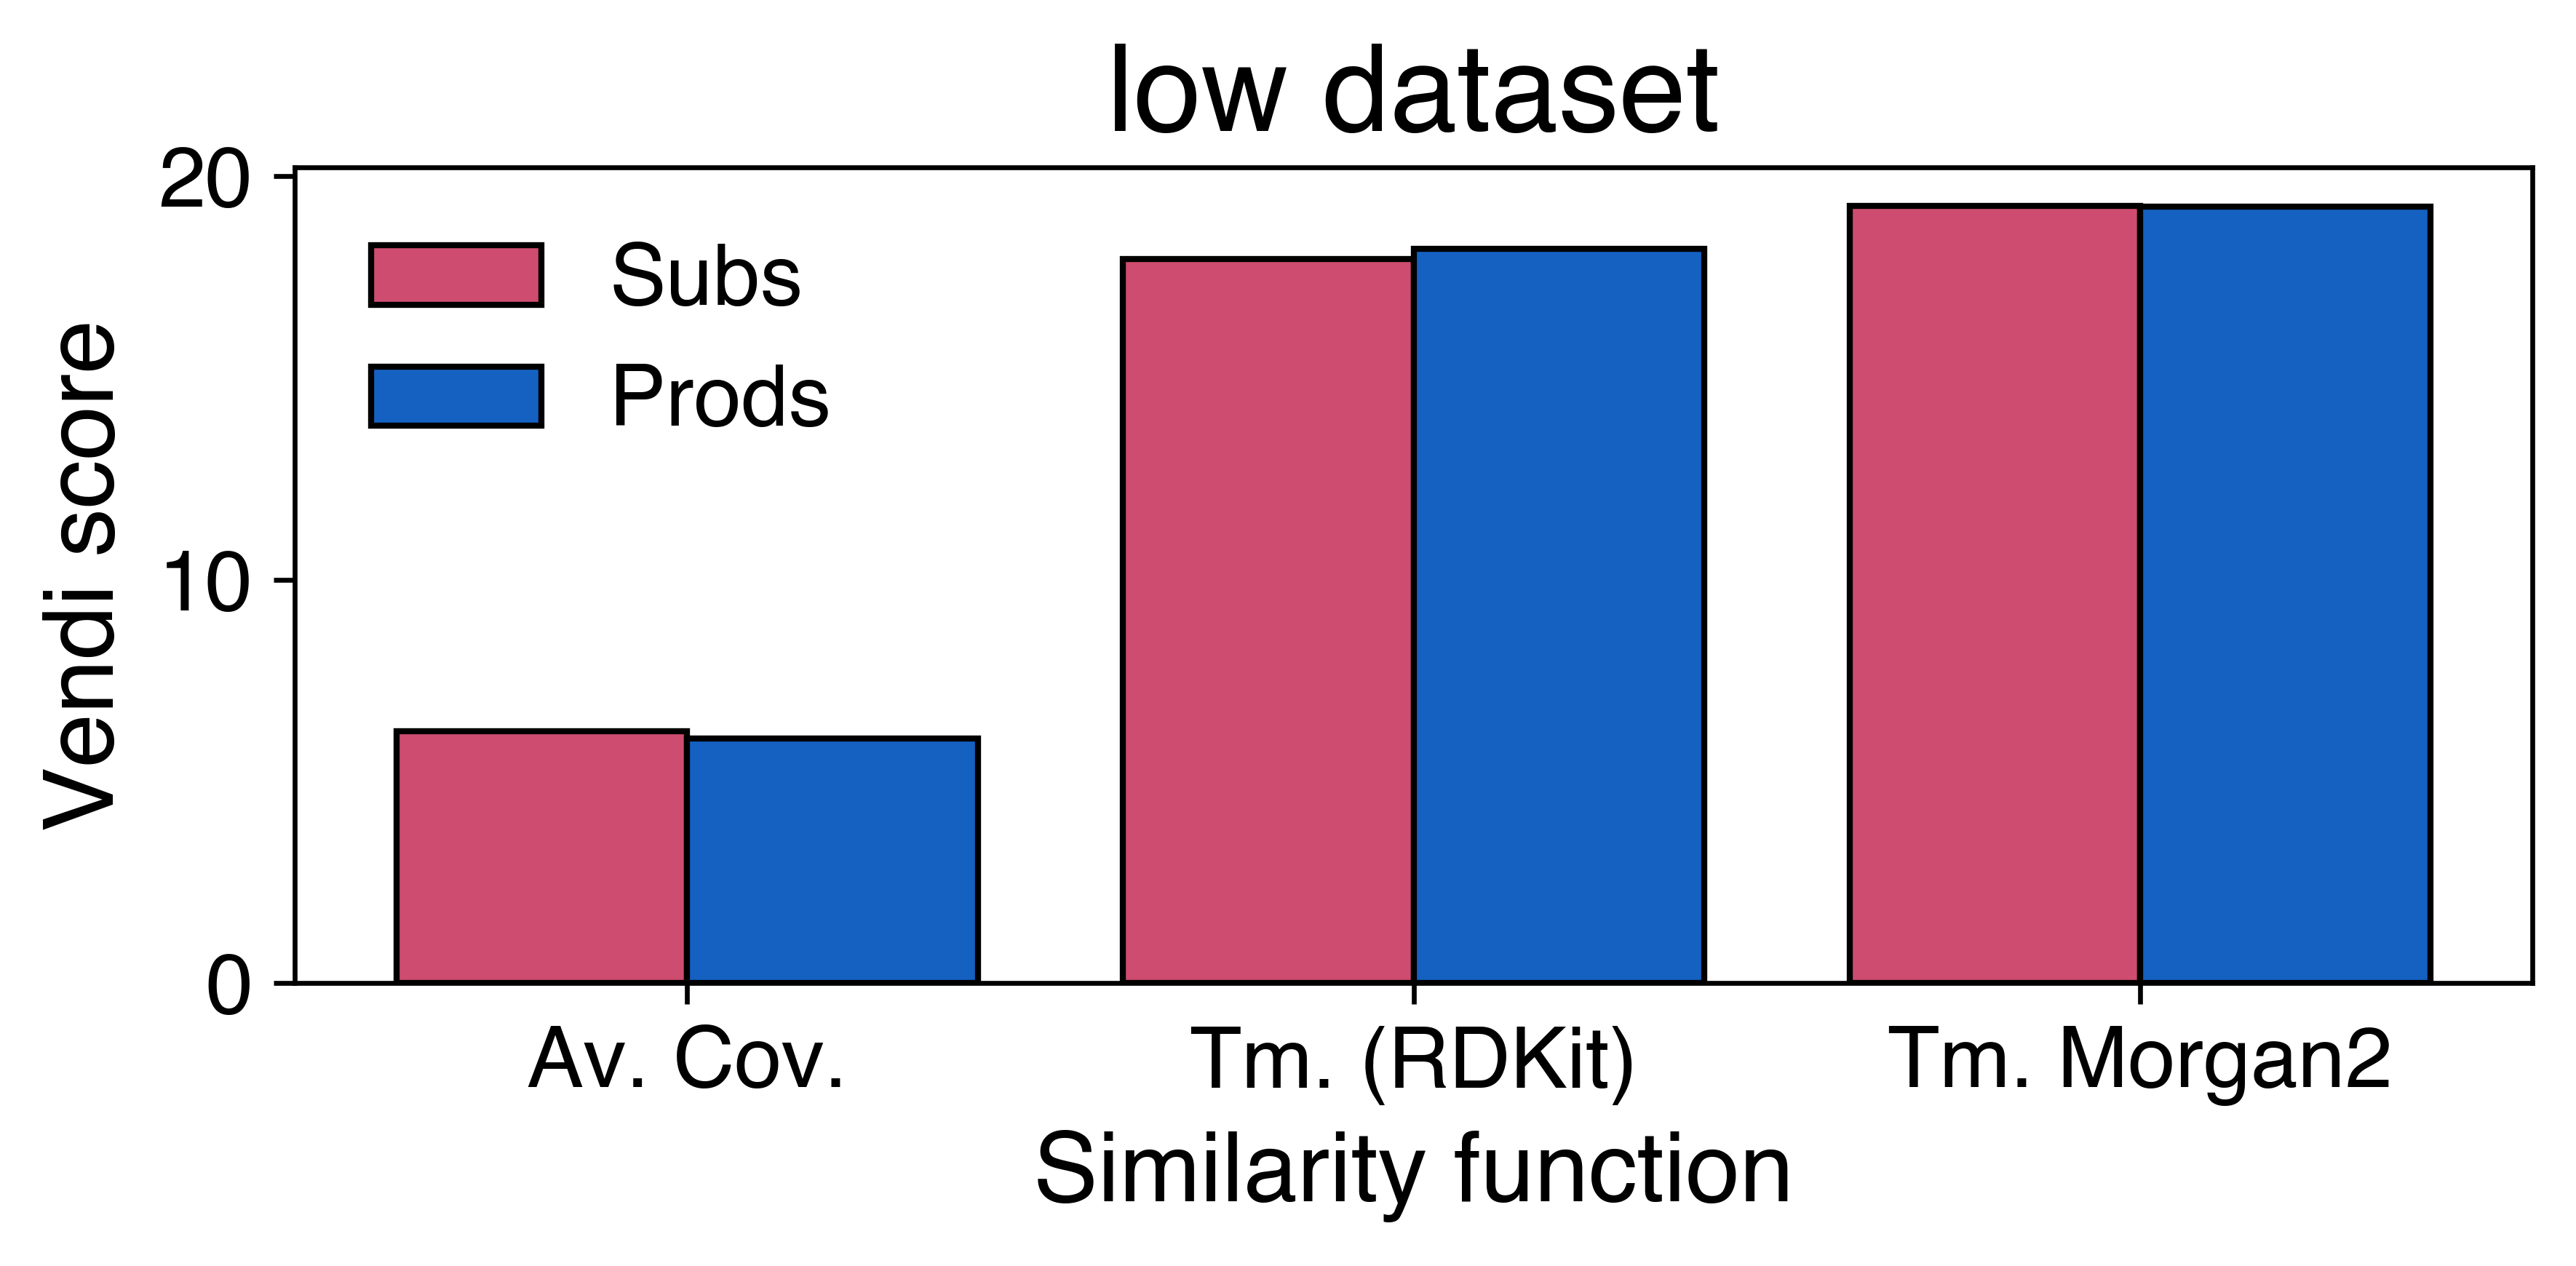

In [27]:
# Set up positions for grouped bars
x = np.arange(len(final_scores["high"].columns))
labels = ["Av. Cov.", "Tm. (RDKit)", "Tm. Morgan2"]
width = 0.4  # width of the bars
for dset in datasets:

    sub_values = final_scores[dset].iloc[1]
    prod_values = final_scores[dset].iloc[0]

    plt.figure(figsize=(6, 3), dpi=600)
    plt.bar(x - width/2, sub_values, width, label = 'Subs', color=all_colors[0], edgecolor='k')
    plt.bar(x + width/2, prod_values, width, label='Prods', color=all_colors[1], edgecolor='k')
    plt.xticks(x, labels)
    plt.ylabel('Vendi score')
    plt.xlabel('Similarity function')
    plt.legend(frameon=False)
    plt.title(f"{dset} dataset")

    # # Add values
    # for i, v in enumerate(means_original):
    #     plt.text(x[i] - width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=12, c ="white")
    # for i, v in enumerate(means_pruned):
    #     plt.text(x[i] + width/2, 2, f'{v:.1f}', ha='center', va='bottom', fontsize=12,c="white")

    plt.tight_layout()
    plt.show()

There is very negligible difference in the Vendi scores calculated via the two different Tanimoto similarities. In the case of the average covariance, one dataset favores each featurization a bit while the third one does not show a difference between the featurizations. In summary, there is no strong preference for product or substrate descriptors.